In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [64]:
df = pd.read_csv("./individual_book_train/stock_53.csv")

def wap(df: pd.DataFrame) -> pd.DataFrame:
    full_seconds = pd.DataFrame({'seconds_in_bucket': range(600)})
    
    merged_df = pd.merge(full_seconds, df, on='seconds_in_bucket', how='left')
    merged_df['WAP'] = merged_df['WAP'].fillna(method='ffill')
    return merged_df

df['WAP'] = (df['bid_price1']*df['ask_size1'] + df['ask_price1']*df['bid_size1']) /\
    (df['bid_size1'] + df['ask_size1'])
df_filtered = df[df['time_id'] == 18944][['WAP','seconds_in_bucket']]
df_filtered = wap(df_filtered)

df_train = df_filtered.loc[df_filtered['seconds_in_bucket'] < 400, "WAP"]
df_test = df_filtered.loc[df_filtered['seconds_in_bucket'] >= 400, "WAP"]

0        0
1        1
2        2
3        3
4        4
      ... 
395    395
396    396
397    397
398    398
399    399
Name: seconds_in_bucket, Length: 400, dtype: int64

The plot visually seems linearly growing.

### Model Building

In [68]:
X_train = df_filtered.loc[df_filtered['seconds_in_bucket'] < 400, "seconds_in_bucket"].values.reshape(-1, 1)
y_train = df_filtered.loc[df_filtered['seconds_in_bucket'] < 400, "WAP"]

X_test = df_filtered.loc[df_filtered['seconds_in_bucket'] >= 400, "seconds_in_bucket"].values.reshape(-1, 1)
y_test = df_filtered.loc[df_filtered['seconds_in_bucket'] >= 400, "WAP"]

##### Linear regression

In [66]:
model = LinearRegression().fit(X_train, y_train)
m = model.coef_[0]
b = model.intercept_

print(f"y = {m:.2e}x + {b:.5}")

y = 2.76e-06x + 1.0012


This is the predicted regression model for this data frame.

In [72]:
y_pred = model.predict(X_train)

In [46]:
r_squared_train = model.score(X, y_test)
mapeline = mean_absolute_percentage_error(y_test, y_pred)
print(f'R-squared value: {r_squared_train:.2f}')
print(f'Mean Absolute Percentage Error - linear: {mapeline:.2e}')

R-squared value: -5.93
Mean Absolute Percentage Error - linear: 8.04e-04


##### Polynomial Regression

In [37]:
r_squared_values = []
mape_values = []

for degree in range(1, 10):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression().fit(X_poly, y)
    
    r_squared = model.score(X_poly, y)
    r_squared_values.append(r_squared)
    
    y_pred = model.predict(X_poly)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mape_values.append(mape)

min_mape = min(mape_values)
min_degree = degrees[mape_values.index(min_mape)]
print(f"Minimum MAPE: {min_mape:.2e} at degree: {min_degree}")
print(f"Maximum R-squared value: {max(r_squared_values):.2f} at degree: {degrees[r_squared_values.index(max(r_squared_values))]}")

Minimum MAPE: 8.04e-04 at degree: 2
Maximum R-squared value: 0.79 at degree: 7


#### Prediction
##### Linear Regression

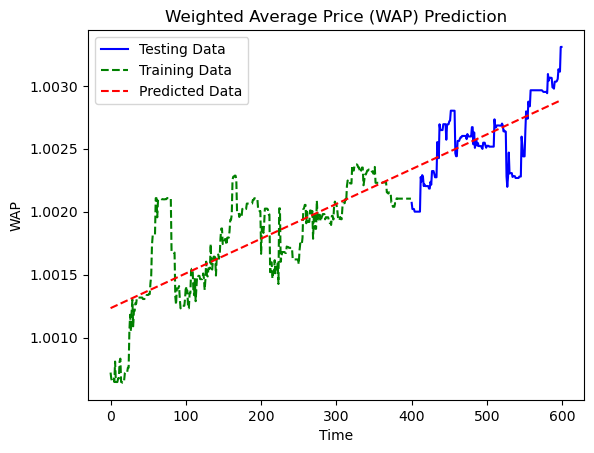

Mean Absolute Percentage Error - linear: 5.45e-04


In [86]:
model = LinearRegression().fit(X_train, y_train)
future_x_values = np.linspace(np.min(X_train), np.max(X_train) + 200, 200).reshape(-1, 1)
future_y_values = model.predict(future_x_values)


plt.title('Weighted Average Price (WAP) Prediction')
plt.xlabel('Time')
plt.ylabel('WAP')
plt.plot(X_test, y_test, label='Testing Data', color='blue')
plt.plot(X_train, y_train, label = 'Training Data', color = 'green', linestyle='--')
plt.plot(future_x_values, future_y_values, label='Predicted Data', color='red', linestyle='--')
plt.legend()
plt.show()

mapepre = mean_absolute_percentage_error(y_test, future_y_values)
print(f'Mean Absolute Percentage Error - linear: {mapepre:.2e}')